# Modeling Climate and Housing Data
## Question 1: Can we predict real estate purchase price based on climate indicators?
## 90-803 Machine Learning Foundations with Python (Spring 2024)
### Team 17: Yoko, Tessa, Hannah

We are attempting to predict home values (or purchase prices) based on climate indicators. In this extra/complementary notebook, we are exploring what it would look like to build a Linear Regression _for every county_ based on temperature anomalies and purchase price. The question is whether or not some states will have a stronger correlation than the average.

### Load Libraries

In [2]:
# importing relevant libraries
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
%matplotlib inline

# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.feature_selection import SequentialFeatureSelector

# Importing class balance tools for handling imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from yellowbrick.target import ClassBalance

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import DBSCAN, HDBSCAN
# Import plotyly
import plotly.express as px

# Import state abbreviations and FIPS
from state_names import state_abbreviations, state_to_fips

### Load Data

In [3]:
# Read CSVs and do the same modifications that we explained in Q1_Regression_Analysis.ipynb
data = pd.read_csv("all_data.csv", index_col=0)
data.drop(columns=['Date'], inplace=True)
data.rename(columns={'Value': 'Average Temperature Value'}, inplace=True)
data['StateFPS'] = data['StateAbbrv'].map(state_to_fips)
print(data.shape)
mask = ~data['Year'].isin([2008, 2012])
data = data[mask]
data.head()

(596366, 18)


,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,StateAbbrv,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),StateFPS
0,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,CA,0.93,8.01,15,103.0,173.6,64.7,7.0,06
1,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,CA,0.81,8.20,30,129.9,166.8,81.1,61.1,06
2,2000,1,Cook County,IL,71689.188026,302264.545103,24.9,2.4,22.5,IL,0.93,8.01,15,103.0,173.6,64.7,7.0,17
3,2000,1,Cook County,IL,71689.188026,302264.545103,24.9,2.4,22.5,IL,0.81,8.20,30,129.9,166.8,81.1,61.1,17
4,2000,1,Harris County,TX,61195.175569,217850.462915,57.4,5.6,51.8,TX,0.93,8.01,15,103.0,173.6,64.7,7.0,48


In [4]:
# Loading the shapefile in order to visualize clean data on the US map
def merge_dfs(us_counties, data):
    data = us_counties.merge(data, left_on=['NAMELSAD', 'STATEFP'], right_on=['RegionName', 'StateFPS'])
    return data

us_counties = gpd.read_file('tl_2022_us_county/tl_2022_us_county.shp')

merged_data = merge_dfs(us_counties, data)
print(merged_data.columns)
merged_data.head()

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'Year', 'Month',
       'RegionName', 'State', 'Bottom-Tier Average Home Value Estimate',
       'Top-Tier Average Home Value Estimate', 'Average Temperature Value',
       'Anomaly (1901-2000 base period)', '1901-2000 Mean', 'StateAbbrv',
       'Initial Fees and Charges (%)', 'Effective Rate (%)',
       'Term to Maturity', 'Loan Amount ($thou)', 'Purchase Price ($thou)',
       'Loan-to-Price Ratio (%)', 'Share of Total Market (%)', 'StateFPS'],
      dtype='object')


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,1901-2000 Mean,StateAbbrv,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),StateFPS
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,22.2,NE,0.93,8.01,15,103.0,173.6,64.7,7.0,31
1,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,22.2,NE,0.81,8.20,30,129.9,166.8,81.1,61.1,31
2,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,27.3,NE,0.91,8.18,15,100.5,172.8,63.1,7.2,31
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,27.3,NE,0.78,8.39,30,127.8,163.7,81.2,58.6,31
4,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,38.0,NE,0.87,8.24,15,101.2,176.9,62.7,7.2,31


In [5]:
def split_train_test(data):
   # data.drop(columns=['RegionName', 'State','StateFPS', 'StateAbbrv'], inplace=True)
    test = data[data['Year'] == 2019].copy()
    train = data[data['Year'] != 2019].copy()
    return train, test

def scale_train_test(train, test):
    columns_to_scale = train.drop(columns=['RegionName', 'State', 'StateFPS', 'StateAbbrv', 
                                           'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
                        'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).columns

    # Create a MinMaxScaler object -- we are using this because we actually WANT outliers to stand out.
    scaler = MinMaxScaler()

    # Fit the scaler to the specified columns
    scaler.fit(train[columns_to_scale])

    # Transform the train using the fitted scaler and convert it back to a trainFrame
    scaled_train = scaler.transform(train[columns_to_scale])
    scaled_train = pd.DataFrame(scaled_train, columns=columns_to_scale, index=train.index)
    scaled_train['Year'] = train['Year']
    scaled_train['Month'] = train['Month']
    scaled_train['RegionName'] = train['RegionName']
    scaled_train['State'] = train['State']
    scaled_train['StateFPS'] = train['StateFPS']
    scaled_train['StateAbbrv'] = train['StateAbbrv']

    # Transform the test data and put back the other columns
    scaled_test = scaler.transform(test[columns_to_scale])
    scaled_test = pd.DataFrame(scaled_test, columns=columns_to_scale, index=test.index)
    scaled_test['Year'] = test['Year']
    scaled_test['Month'] = test['Month']
    scaled_test['RegionName'] = test['RegionName']
    scaled_test['State'] = test['State']
    scaled_test['StateFPS'] = test['StateFPS']
    scaled_test['StateAbbrv'] = test['StateAbbrv']

    return scaled_train, scaled_test

def split_X_Y(train, test):
    X_train = train.drop(columns=['Purchase Price ($thou)', 'RegionName', 'State', 'StateFPS', 'StateAbbrv'])
    y_train = train['Purchase Price ($thou)'].copy()
    X_test = test.drop(columns=['Purchase Price ($thou)', 'RegionName', 'State', 'StateFPS', 'StateAbbrv'])
    y_test = test['Purchase Price ($thou)'].copy()
    return X_train, y_train, X_test, y_test

# We know what features we selected previously and we are just going to go with that
def select_features(train, test):
    train = train.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])
    test = test.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])
    return train, test

In [6]:
# Call all these functions to get the overall data
train, test = split_train_test(merged_data)
train_scaled, test_scaled = scale_train_test(train, test)
train_selected, test_selected = select_features(train_scaled, test_scaled)
print(train_selected.columns)
train_selected.head()

Index(['Year', 'Average Temperature Value', 'Anomaly (1901-2000 base period)',
       '1901-2000 Mean', 'Effective Rate (%)', 'Loan Amount ($thou)',
       'Purchase Price ($thou)', 'Loan-to-Price Ratio (%)',
       'Share of Total Market (%)', 'RegionName', 'State', 'StateFPS',
       'StateAbbrv'],
      dtype='object')


,Year,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Effective Rate (%),Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),RegionName,State,StateFPS,StateAbbrv
0,2000,0.323972,0.619597,0.226919,0.904425,0.088942,0.240194,0.524051,0.073077,Lancaster County,NE,31,NE
1,2000,0.323972,0.619597,0.226919,0.938053,0.250601,0.207264,0.939241,0.766667,Lancaster County,NE,31,NE
2,2000,0.403210,0.700288,0.283648,0.934513,0.073918,0.236320,0.483544,0.075641,Lancaster County,NE,31,NE
3,2000,0.403210,0.700288,0.283648,0.971681,0.237981,0.192252,0.941772,0.734615,Lancaster County,NE,31,NE
4,2000,0.481444,0.616715,0.402670,0.945133,0.078125,0.256174,0.473418,0.075641,Lancaster County,NE,31,NE


In [7]:
scaled_X_train, scaled_y_train, scaled_X_test, scaled_y_test = split_X_Y(train_selected, test_selected)
print(scaled_X_train.columns)
scaled_X_train.head()

Index(['Year', 'Average Temperature Value', 'Anomaly (1901-2000 base period)',
       '1901-2000 Mean', 'Effective Rate (%)', 'Loan Amount ($thou)',
       'Loan-to-Price Ratio (%)', 'Share of Total Market (%)'],
      dtype='object')


,Year,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Effective Rate (%),Loan Amount ($thou),Loan-to-Price Ratio (%),Share of Total Market (%)
0,2000,0.323972,0.619597,0.226919,0.904425,0.088942,0.524051,0.073077
1,2000,0.323972,0.619597,0.226919,0.938053,0.250601,0.939241,0.766667
2,2000,0.403210,0.700288,0.283648,0.934513,0.073918,0.483544,0.075641
3,2000,0.403210,0.700288,0.283648,0.971681,0.237981,0.941772,0.734615
4,2000,0.481444,0.616715,0.402670,0.945133,0.078125,0.473418,0.075641


## For county, let's do a linear regression of temperature anomaly and housing prices

In [8]:
def linear_regression_temp_purch_price(data):
    # Create model object
    model = LinearRegression()
    X = data['Anomaly (1901-2000 base period)'].values.reshape(-1, 1)
    y = data['Purchase Price ($thou)'].values

    model.fit(X, y)

    y_pred = model.predict(X)

    # Calculate R-squared and MSE
    r_squared = model.score(X, y)
    mse = mean_squared_error(y, y_pred)

    # Return the data we want
    return pd.Series({
        'R_squared': r_squared,
        'MSE': mse,
        'Slope': model.coef_[0],
        'Intercept': model.intercept_
    })

train_regression_results = train_selected.groupby(['RegionName', 'State']).apply(linear_regression_temp_purch_price).reset_index()
train_regression_results.head()

C:\Users\quint\AppData\Local\Temp\ipykernel_23544\3740640245.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_regression_results = train_selected.groupby(['RegionName', 'State']).apply(linear_regression_temp_purch_price).reset_index()


,RegionName,State,R_squared,MSE,Slope,Intercept
0,Acadia Parish,LA,0.000893,0.004977,-0.022373,0.840530
1,Ada County,ID,0.006864,0.025418,0.151530,0.563901
2,Adair County,MO,0.053982,0.007239,0.165976,0.712812
3,Adams County,CO,0.001388,0.031790,0.073918,0.576994
4,Adams County,IL,0.009725,0.023774,0.131391,0.650716


In [9]:
train_regression_results.sort_values(by='R_squared', ascending=False).head()

,RegionName,State,R_squared,MSE,Slope,Intercept
1027,Meade County,SD,0.169284,0.004245,-0.214822,0.949624
335,Codington County,SD,0.140592,0.004390,-0.201481,0.941189
1372,Santa Barbara County,CA,0.128635,0.027739,0.981986,0.121887
871,Lauderdale County,MS,0.127520,0.006676,0.316995,0.641452
1443,Stanley County,SD,0.127404,0.004459,-0.189471,0.937162


In [10]:
train_regression_results.sort_values(by='MSE', ascending=True).head()

,RegionName,State,R_squared,MSE,Slope,Intercept
1235,Phillips County,AR,0.019747,0.003518,-0.084309,0.910578
631,Hale County,AL,0.002595,0.003579,-0.031806,0.885878
1016,McHenry County,ND,0.001155,0.003585,-0.016690,0.878929
1027,Meade County,SD,0.169284,0.004245,-0.214822,0.949624
335,Codington County,SD,0.140592,0.004390,-0.201481,0.941189


<Axes: xlabel='MSE', ylabel='R_squared'>

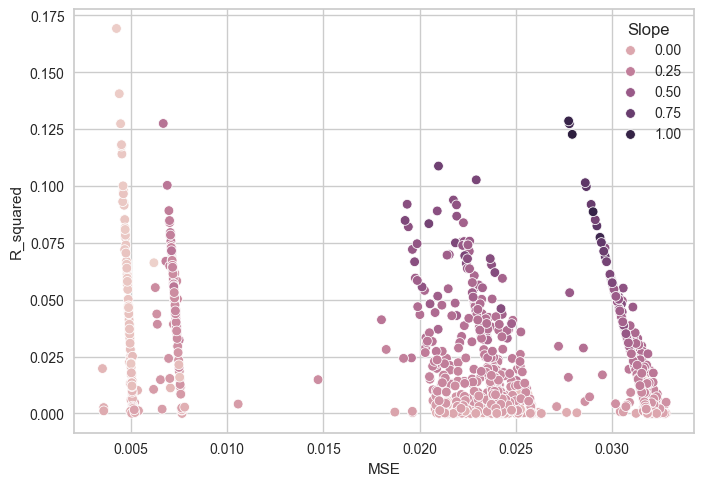

In [11]:
sns.scatterplot(train_regression_results, x='MSE', y='R_squared', hue='Slope')

The highest slops also have relatively high R squared values -- but _also_ have relatively high MSE. This means that that data is a little bit noisy, which corroborates Hannah's results.

<Axes: xlabel='R_squared', ylabel='Count'>

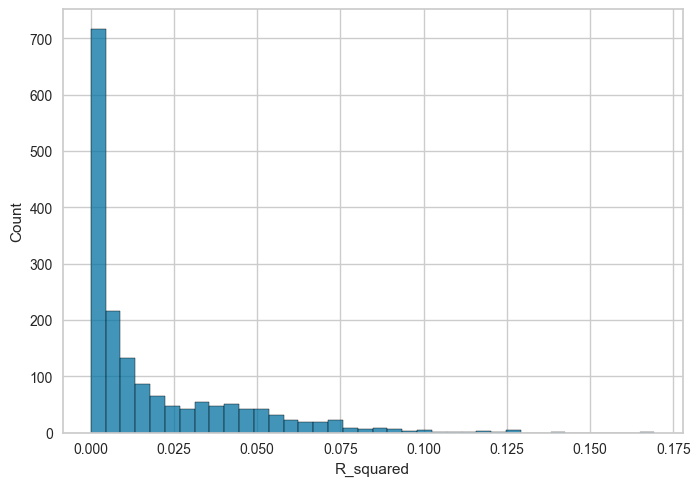

In [12]:
sns.histplot(train_regression_results, x='R_squared')

Overwhelmingly, R2 values are near 0, which is why the values that are above 0.08 do stand out to me (they are outliers, even if the correlation is not strong).

<Axes: xlabel='MSE', ylabel='Count'>

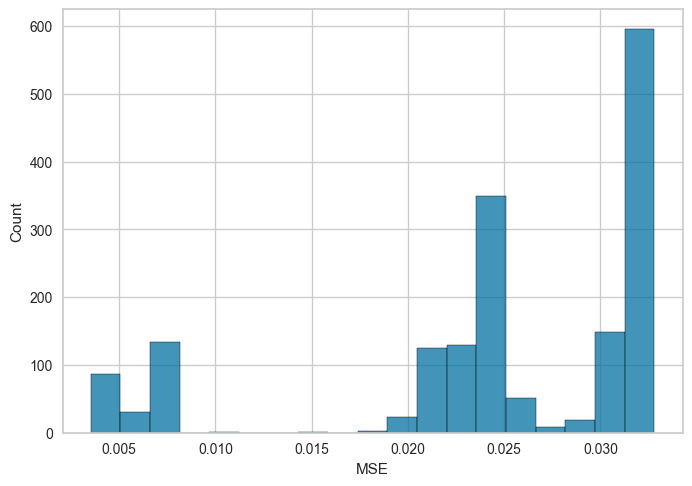

In [13]:
sns.histplot(train_regression_results, x='MSE')

This is interesting because it's kind of trimodel or even quad-modal. We also know that the outliers with high slopes and relatively high R2 had higher MSE.

In [14]:
# Put the geodata back in order to map it
train_regression_results['StateFPS'] = train_regression_results['State'].map(state_to_fips)
train_regression_merged = merge_dfs(us_counties, train_regression_results)
train_regression_merged.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,INTPTLAT,INTPTLON,geometry,RegionName,State,R_squared,MSE,Slope,Intercept,StateFPS
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523...",Lancaster County,NE,0.001487,0.031787,-0.062124,0.641261,31
1,46,099,01265772,46099,Minnehaha,Minnehaha County,06,H1,G4020,None,...,+43.6674723,-096.7957261,"POLYGON ((-96.60910 43.50043, -96.61070 43.500...",Minnehaha County,SD,0.005663,0.022373,0.096920,0.652315,46
2,39,063,01074044,39063,Hancock,Hancock County,06,H1,G4020,None,...,+41.0002170,-083.6659471,"POLYGON ((-83.61191 41.16739, -83.60513 41.167...",Hancock County,OH,0.001752,0.031779,0.067206,0.580669,39
3,48,189,01383880,48189,Hale,Hale County,06,H1,G4020,None,...,+34.0684364,-101.8228879,"POLYGON ((-102.09041 34.31313, -102.08890 34.3...",Hale County,TX,0.000029,0.024126,0.010457,0.705212,48
4,48,011,01383791,48011,Armstrong,Armstrong County,06,H1,G4020,None,...,+34.9641790,-101.3566363,"POLYGON ((-101.62512 35.00070, -101.62509 35.0...",Armstrong County,TX,0.040388,0.007343,0.216896,0.684136,48


Text(0.5, 1.0, 'R Squared Values for Linear Regressions between Temperature Anomalies and Housing Purchase Prices')

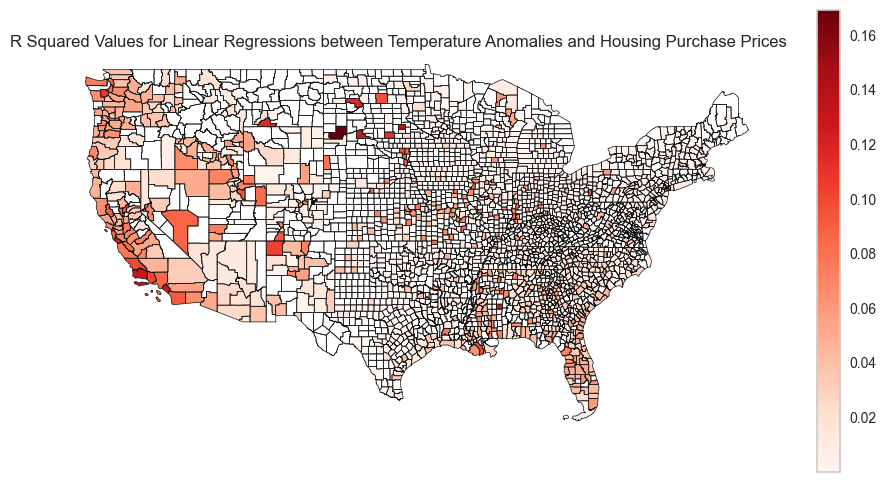

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)
ax.set_axis_off()
us_counties.geometry.boundary.plot(ax=ax, edgecolor='k', linewidth = 0.5)
train_regression_merged.plot(column='R_squared', ax=ax,\
                              cmap='Reds', legend=True).set_title("R Squared Values for Linear Regressions between Temperature Anomalies and Housing Purchase Prices")

Our highest R2 values are mostly along the coast of California -- and they still aren't that high, but they're not 0 either. 

Text(0.5, 1.0, 'MSE Values for Linear Regressions between Temperature Anomalies and Housing Purchase Prices')

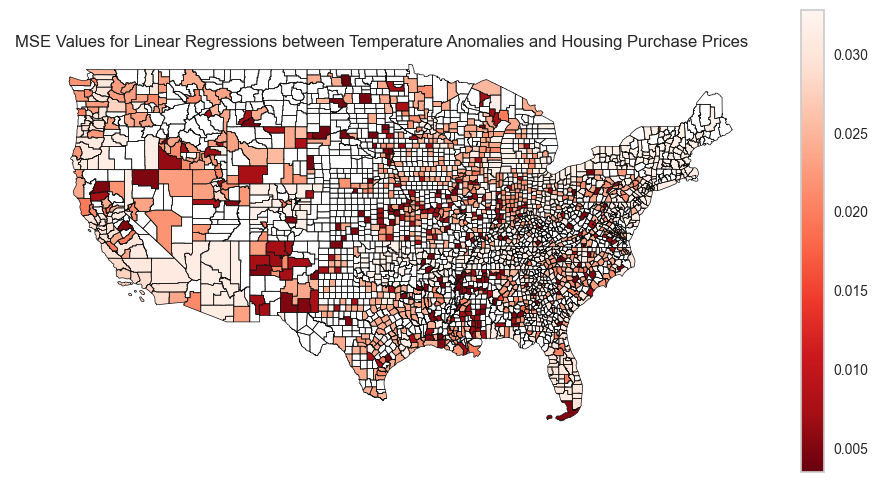

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)
ax.set_axis_off()
us_counties.geometry.boundary.plot(ax=ax, edgecolor='k', linewidth = 0.5)
train_regression_merged.plot(column='MSE', ax=ax, \
                             cmap='Reds_r', legend=True).set_title("MSE Values for Linear Regressions between Temperature Anomalies and Housing Purchase Prices")

Our lowest MSE values (meaning we are most confident that the linear regression is not noisy) still occur in warm states.

Text(0.5, 1.0, 'Slopes of Linear Regressions between Temperature Anomalies and Housing Purchase Prices')

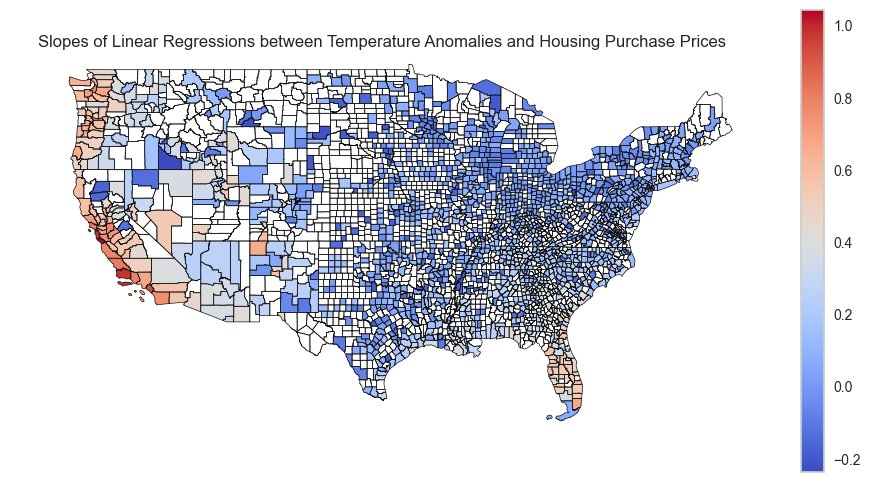

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)
ax.set_axis_off()
us_counties.geometry.boundary.plot(ax=ax, edgecolor='k', linewidth = 0.5)
train_regression_merged.plot(column='Slope', ax=ax, \
                             cmap='coolwarm', legend=True).set_title("Slopes of Linear Regressions between Temperature Anomalies and Housing Purchase Prices")